# Q1: Simple CNN network for PASCAL multi-label classification (20 points)
Now let’s try to recognize some natural images. We provided some starter code for this task. The following steps will guide you through the process.


## 1.1 Setup the dataset
We start by modifying the code to read images from the PASCAL 2007 dataset. The important thing to note is that PASCAL can have multiple objects present in the same image. Hence, this is a multi-label classification problem, and will have to be tackled slightly differently.


First, download the data. `cd` to a location where you can store 0.5GB of images. Then run:
```
wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
tar -xf VOCtrainval_06-Nov-2007.tar

wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
tar -xf VOCtest_06-Nov-2007.tar
cd VOCdevkit/VOC2007/
```

## 1.2 Write a dataloader with data augmentation (5 pts)
**Dataloader** The first step is to write a [pytorch data loader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) which loads this PASCAL data. Browse the folders and files under `VOCdevkit` to understand the structure and labeling. Complete the functions `preload_anno` and `__getitem__` in `voc_dataset.py` according to the following instructions and the instructions in the code. More information about the dataset can be found [here](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/devkit_doc_07-Jun-2007.pdf). We will use data in ‘trainval’ for training and ‘test’ for testing.

- `preload_anno`: This function will be called when the dataloader is initialized. We will load the annotations under folder `Annotations`. Each .xml file in the `Annotations` folder corresponds to the image with the same name under `JPEGImages`. In this function, we need to load `label` and `weight` vectors for each image according to the .xml file. 
- The labels should be 0 by default. Assign 1 for each class label in the .xml file. For example, in 000001.xml, the label vector should have 1s at the class indices correspond to 'dog' and 'person'. The rest of the vector should be 0.
- The weights should be 1 by defatul. For each class label in the image, if 'difficult'=1 (which means it is ambiguous), we will assign 0 for the weight vector at this class index. This weight will be used when we calculate the test performance. We will not consider the ambiguous labels during testing.

- `__getitem__`: This function will be called when the dataloader is called during training. It takes as input the index, and returns a tuple - `(image, label, weight)`. You need to load the image from the `JPEGImages` folder and load the corresponding label and weight using `self.anno_list`.


**Data Augmentation** Modify `__getitem__` to randomly *augment* each datapoint using [TORCHVISION.TRANSFORMS](https://pytorch.org/vision/stable/transforms.html).  Make sure the data augmentation is only used for training data (based on self.split). Please describe what data augmentation you implement.

- Before any augmentation, resize all the images based on `self.size`.

* **Hint**: Since we are training a model from scratch on this small dataset, it is important to perform basic data augmentation to avoid overfitting. Add random crops and left-right flips when training, and do a center crop when testing, etc. As for natural images, another common practice is to subtract the mean values of RGB images from ImageNet dataset. The mean values for RGB images are: `[123.68, 116.78, 103.94]`. You may also rescale the images to `[−1, 1]`. There is no "correct" answer here! Feel free to search online about the data augmentation methods people usually use.

### DESCRIBE YOUR AUGMENTATION PIPELINE HERE**
**Train Augmentations:**
Resize(): resize the image to size req for simple_cnn it is 64, for caffenet, resnet it is 224
RandomCrop: crops random portions of image(for some models, caffenet)
RandomHorizontalFlip(p=0.5): flips the image horizontally with a probability of 0.5 (every 1 in 2)
ToTensor(): converts PIL image to tensor(0-1)
Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])]): normalize with imagenet mean and std.
<br>

**Test Augmentations:**
Resize(): same as train
CenterCrop(): crops from the center, so basically image is unchanged
ToTensor(): same as train
Normalize(mean = [0.485, 0.456, 0.406], std =  [0.229, 0.224, 0.225])]): same as train

## 1.3 Measure Performance (5 pts)
To evaluate the trained model, we will use a standard metric for multi-label evaluation - [mean average precision (mAP)](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html). Please implement `eval_dataset_map` in `utils.py` - this function will evaluate a model's map score using a given dataset object. You will need to make predictions on the given dataset with the model and call `compute_ap` to get average precision.


Please describe how to compute AP for each class(not mAP).
**YOUR ANSWER HERE**

For each class, valid ground truths and valid predictions are selected. Valid data are those which has difficulty as 1, that means the corresponding class is not ambigous. Then recall and precision are calculated and precision is calculated as a weighted average of recall and returned for each class.


## 1.4 Let's Start Training! (5 pts)
Fill out the loss function for multi-label classification in `trainer.py` and start training. In this question, you will use the model that you finished in the previous question (with proper non-linearities).

Initialize a fresh model and optimizer. Then run your training code for 5 epochs and print the mAP on test set. The resulting mAP should be around 0.24. Make sure to tune the hyperparameters.

In [3]:
import torch
import trainer
from utils import ARGS
from simple_cnn import SimpleCNN
from voc_dataset import VOCDataset

# create hyperparameter argument class
# Use image size of 64x64 in Q1. We will use a default size of 224x224 for the rest of the questions.
args = ARGS(epochs=5, inp_size=64, lr=0.001, batch_size=64, gamma=.5, use_cuda=True, \
            log_every=10, val_every=10, step_size=3)
print(args)

args.batch_size = 64
args.device = cuda
args.epochs = 5
args.gamma = 0.5
args.inp_size = 64
args.log_every = 10
args.lr = 0.001
args.save_at_end = False
args.save_freq = -1
args.step_size = 3
args.test_batch_size = 256
args.val_every = 10



In [4]:
# initializes the model
model = SimpleCNN(num_classes=len(VOCDataset.CLASS_NAMES), inp_size=64, c_dim=3)
# initializes Adam optimizer and simple StepLR scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma)
# trains model using your training code and reports test map
test_ap, test_map = trainer.train(args, model, optimizer, scheduler, "simple_cnn")
print('test map:', test_map)

Train Epoch: 0 [0 (0%)]	Loss: 0.687220
Train Epoch: 0 [10 (13%)]	Loss: 0.273261
Train Epoch: 0 [20 (25%)]	Loss: 0.244007
Train Epoch: 0 [30 (38%)]	Loss: 0.240804
Train Epoch: 0 [40 (51%)]	Loss: 0.233130
Train Epoch: 0 [50 (63%)]	Loss: 0.245571
Train Epoch: 0 [60 (76%)]	Loss: 0.228997
Train Epoch: 0 [70 (89%)]	Loss: 0.242867
Train Epoch: 1 [80 (1%)]	Loss: 0.215927
Train Epoch: 1 [90 (14%)]	Loss: 0.227102
Train Epoch: 1 [100 (27%)]	Loss: 0.232885
Train Epoch: 1 [110 (39%)]	Loss: 0.198880
Train Epoch: 1 [120 (52%)]	Loss: 0.221349
Train Epoch: 1 [130 (65%)]	Loss: 0.224932
Train Epoch: 1 [140 (77%)]	Loss: 0.213901
Train Epoch: 1 [150 (90%)]	Loss: 0.225216
Train Epoch: 2 [160 (3%)]	Loss: 0.206045
Train Epoch: 2 [170 (15%)]	Loss: 0.208174
Train Epoch: 2 [180 (28%)]	Loss: 0.240340
Train Epoch: 2 [190 (41%)]	Loss: 0.247462
Train Epoch: 2 [200 (53%)]	Loss: 0.208283
Train Epoch: 2 [210 (66%)]	Loss: 0.213972
Train Epoch: 2 [220 (78%)]	Loss: 0.223647
Train Epoch: 2 [230 (91%)]	Loss: 0.205570
Train 

## Results of tuned hyperparameters
Testing MAP vs iteration number
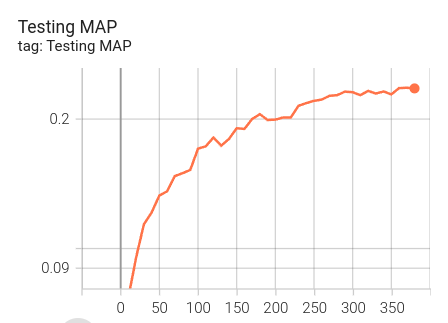

Training loss vs iteration number
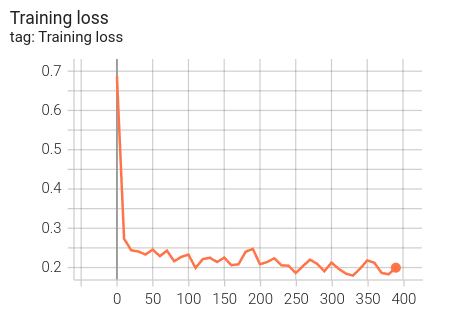

[TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard) is an awesome visualization tool. It was firstly integrated in [TensorFlow](https://www.tensorflow.org/). It can be used to visualize training losses, network weights and other parameters.

To use TensorBoard in Pytorch, there are two options: [TensorBoard in Pytorch](https://pytorch.org/docs/stable/tensorboard.html) (for Pytorch >= 1.1.0) or [TensorBoardX](https://github.com/lanpa/tensorboardX) - a third party library. Following these links to add code in `trainer.py` to visualize the testing MAP and training loss in Tensorboard. *You may have to reload the kernel for these changes to take effect.*

Show clear screenshots of the learning curves of testing MAP and training loss for 5 epochs (batch size=20, learning rate=0.001). Please evaluate your model to calculate the MAP on the testing dataset every 100 iterations.

In [7]:
args = ARGS(epochs=5, batch_size=20, lr=0.001, inp_size=64, val_every=100, step_size=5)
model = SimpleCNN(num_classes=len(VOCDataset.CLASS_NAMES), inp_size=64, c_dim=3)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)
test_ap, test_map = trainer.train(args, model, optimizer, scheduler)
print('test map:', test_map)

Train Epoch: 0 [0 (0%)]	Loss: 0.705692
Train Epoch: 0 [100 (40%)]	Loss: 0.237026
Train Epoch: 0 [200 (80%)]	Loss: 0.266471
Train Epoch: 1 [300 (20%)]	Loss: 0.241846
Train Epoch: 1 [400 (59%)]	Loss: 0.249883
Train Epoch: 1 [500 (99%)]	Loss: 0.219120
Train Epoch: 2 [600 (39%)]	Loss: 0.166754
Train Epoch: 2 [700 (79%)]	Loss: 0.192238
Train Epoch: 3 [800 (19%)]	Loss: 0.215409
Train Epoch: 3 [900 (59%)]	Loss: 0.211660
Train Epoch: 3 [1000 (98%)]	Loss: 0.199148
Train Epoch: 4 [1100 (38%)]	Loss: 0.160793
Train Epoch: 4 [1200 (78%)]	Loss: 0.207072
test map: 0.22557861191616416


**INSERT YOUR TENSORBOARD SCREENSHOTS HERE**
Testing MAP vs iteration number
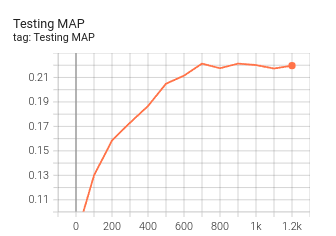

Training loss vs iteration number
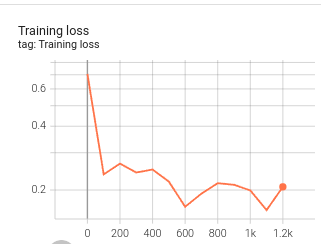